In [1]:
import pandas as pd
import os
from collections import Counter

import numpy as np

from tqdm import tqdm
from konlpy.tag import Okt  # konlpy 설치 시 jdk는 8로
import hanja

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

import matplotlib.pyplot as plt


In [2]:
okt = Okt()
pos_tagset_raw = okt.tagset
print(pos_tagset_raw)

targets = ["명사", "동사", "형용사", "부사", "관형사", "접속사"]  # 조사 제거

pos_tagset = {}
for k, v in pos_tagset_raw.items():
    if v in targets:
        pos_tagset[k] = v

pos_tagset

{'Adjective': '형용사', 'Adverb': '부사', 'Alpha': '알파벳', 'Conjunction': '접속사', 'Determiner': '관형사', 'Eomi': '어미', 'Exclamation': '감탄사', 'Foreign': '외국어, 한자 및 기타기호', 'Hashtag': '트위터 해쉬태그', 'Josa': '조사', 'KoreanParticle': '(ex: ㅋㅋ)', 'Noun': '명사', 'Number': '숫자', 'PreEomi': '선어말어미', 'Punctuation': '구두점', 'ScreenName': '트위터 아이디', 'Suffix': '접미사', 'Unknown': '미등록어', 'Verb': '동사'}


{'Adjective': '형용사',
 'Adverb': '부사',
 'Conjunction': '접속사',
 'Determiner': '관형사',
 'Noun': '명사',
 'Verb': '동사'}

### 텍스트, 데이터 불러와서 처리

In [3]:
# 기준금리 데이터 불러와서 처리하기
with open("./DATA_RAW/한국은행_기준금리_RAW.txt", "r") as f:
    lines = f.readlines()

rows = []
for line in lines:
    yr, m, d, rate = line.strip().split()
    m = m.replace("월", "")
    d = d.replace("일", "")
    
    row = {}
    row["날짜"] = f"{yr}-{m}-{d}"
    row["한국은행 기준금리"] = float(rate)
    rows.append(row)

base_rate = pd.DataFrame(rows)
base_rate = base_rate.sort_values("날짜")
base_rate.set_index("날짜", inplace=True)
base_rate.to_csv("./DATA/data_한국은행 기준금리.csv", index=False)

base_rate.info()
base_rate.tail()

<class 'pandas.core.frame.DataFrame'>
Index: 55 entries, 1999-05-06 to 2023-01-13
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   한국은행 기준금리  55 non-null     float64
dtypes: float64(1)
memory usage: 880.0+ bytes


,한국은행 기준금리
날짜,
2022-07-13,2.25
2022-08-25,2.50
2022-10-12,3.00
2022-11-24,3.25
2023-01-13,3.50


In [4]:
# 연준금리 데이터 불러오기
ffr = pd.read_csv("./DATA_RAW/FFR_raw_data.csv")
ffr.columns = ["날짜", "FFR"]

# 날짜 처리
ffr["날짜"] = pd.to_datetime(ffr["날짜"]).apply(lambda x: x.strftime("%Y-%m-%d"))
ffr = ffr.set_index("날짜")


# 숫자 처리
def ffr_arrange(x):
    sp = [float(s) for s in x.split(" - ")]
    if len(sp) == 2:
        result = sum(sp)/len(sp)
    else:
        result = sp[0]
    return result


ffr["FFR"] = ffr["FFR"].apply(ffr_arrange)
ffr.to_csv("./DATA/data_FFR.csv")

ffr.info()
ffr.tail()
# ffr

<class 'pandas.core.frame.DataFrame'>
Index: 103 entries, 1990-01-01 to 2023-05-03
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FFR     103 non-null    float64
dtypes: float64(1)
memory usage: 1.6+ KB


,FFR
날짜,
2022-11-02,3.875
2022-12-14,4.375
2023-02-01,4.625
2023-03-22,4.875
2023-05-03,5.125


In [5]:
# # 통화정책결정문 불러오기  >> 한자 처리 전

# flist = os.listdir("통화정책결정문")
# flist = [f for f in flist if f[0] != "."]  # .으로 시작하는 파일 제외
# # file = flist[0]

# raw_datas = {}

# for file in flist:  # 파일 하나씩 가져옴

#     # 파일 불러옴
#     with open(f"통화정책결정문/{file}") as f:
#         lines = f.readlines()
#         lines = [line.strip() for line in lines]  # 불필요한 줄바꿈, 공백 제외
#         lines = [line for line in lines if line]  # 빈 라인 제외

#     # 파일의 내용 딕셔너리에 정리
#     data = {}

#     cate = "[도입부]"
#     data[cate] = []  # 빈 리스트 생성

#     for line in lines:
#         if line[0] == "[" and line[-1] == "]":  # 중괄호로 쌓인 내용의 경우
#             cate = line  # 해당 라인을 카테고리명으로 사용
            
#             if cate == "[통화정채방향]":  # 오타 수정
#                 cate = "[통화정책방향]"
            
#             data[cate] = []  # 카테고리 리스트 생성

#         else:  # 카테고리가 아닌 데이터 내용인 경우
#             data[cate].append(line)  # 카테고리별로 한줄 추가
        
#     # 처리한 내용 저장
#     year = file[:4]
#     month = file[4:6]
#     day = file[6:8]
    
#     new_name = f"{year}-{month}-{day}"
#     raw_datas[new_name] = data


# # csv로 저장해두기
# merged_data = []
# for k, v in raw_datas.items():
#     row = {}
#     row["날짜"] = k
    
#     for cate, content in v.items():
#         row[cate] = "\n".join(content)
    
#     merged_data.append(row)

# df = pd.DataFrame(merged_data)
# df.to_csv("통화정책방향_raw.csv", index=False)

# merged_data[0]

In [6]:
# 통화정책결정문 불러오기  >> 한자 처리한 것

flist = os.listdir("통화정책방향_processed")
flist = [f for f in flist if f[0] != "."]  # .으로 시작하는 파일 제외
flist.remove("한자처리")  # 한자처리 폴더 제외
# file = flist[0]

raw_datas = {}

for file in flist:  # 파일 하나씩 가져옴

    # 파일 불러옴
    with open(f"통화정책방향_processed/{file}") as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines]  # 불필요한 줄바꿈, 공백 제외
        lines = [line for line in lines if line]  # 빈 라인 제외
    
    date = file.replace(".txt", "")
    raw_datas[date] = {"[통화정책방향]": lines}


# csv로 저장해두기
merged_data = []
for k, v in raw_datas.items():
    row = {}
    row["날짜"] = k
    
    for cate, content in v.items():
        row[cate] = "\n".join(content)
    
    merged_data.append(row)

df = pd.DataFrame(merged_data)
# df.to_csv("통화정책방향_raw.csv", index=False)

merged_data[4]
merged_data[-1]

{'날짜': '2023-05-25',
 '[통화정책방향]': '금융통화위원회는 다음 통화정책방향 결정시까지 한국은행 기준금리를 현 수준(3.50%)에서 유지하여 통화정책을 운용하기로 하였다. 물가상승률이 둔화 흐름을 지속하겠지만 상당기간 목표수준을 상회할 것으로 전망되는 만큼 현재의 긴축 기조를 유지하는 것이 적절하다고 보았다. 추가 인상 필요성은 대내외 정책 여건의 변화를 점검하면서 판단해 나갈 것이다.\n세계경제는 예상보다 양호한 성장 흐름을 나타내고 있지만 주요국의 통화긴축 기조 지속, 은행부문의 신용공급 축소 등으로 성장세가 점차 둔화될 것으로 예상된다. 글로벌 인플레이션은 둔화 흐름을 이어가고 있지만 여전히 높은 수준이며 근원물가는 상대적으로 더디게 둔화되고 있다.국제금융시장에서는 미 달러화가 미 연준의 금리인상 종료 가능성 시사 등으로 약세를 보이다가 5월 중순 이후 시장 예상을 상회하는 경제지표, 미국 부채한도 협상 등에 영향받으며 등락하였고, 주요국의 장기 국채금리는 좁은 범위에서 변동하다가 상승하였다. 앞으로 세계경제와 국제금융시장은 글로벌 인플레이션의 둔화 속도, 주요국의 통화정책 변화 및 미 달러화 움직임, 미국 중소형은행 리스크와 부채한도 협상, 중국경제의 회복 상황 등에 영향받을 것으로 보인다.\n국내경제는 소비가 서비스를 중심으로 완만한 회복세를 보였지만 수출과 투자 부진이 이어지면서 성장세 둔화가 지속되었다.고용은 전반적으로 양호한 상황이지만 경기 둔화로 취업자수 증가폭이 축소되었다. 앞으로 국내경제는 당분간 부진한 성장 흐름을 이어가겠지만 하반기부터 IT 경기부진 완화, 중국경제 회복의 영향 파급 등으로 점차 회복될 것으로 예상된다. 금년 성장률은 지난 2월 전망치(1.6%)를 하회하는 1.4%로 예상되며, IT 경기 반등 시기, 중국경제 회복의 국내 파급영향 정도, 주요 선진국의 경기 흐름 등과 관련한 불확실성이 높은 상황이다.\n소비자물가는 4월중 상승률이 전월 4.2%에서 3.7%로 낮아지는 등 당초 예상에 부합하는 둔화 흐름

In [7]:
# 통화정책 방향만 뽑은 뒤에 어간만 추출

# 통화정책방향만 뽑기
direction_statements = {}  # 통화정책방향
for k, v in raw_datas.items():
    direction_statements[k] = {}
    direction_statements[k]["raw"] = v["[통화정책방향]"]
    # direction_statements[k]["merged"] = " ".join(v["[통화정책방향]"])  # 공백 넣어서 합치기
    
# 어간 추출
okt = Okt()

print("Target pos set:", pos_tagset)

for k in tqdm(direction_statements):
    text = " ".join(direction_statements[k]["raw"])  # 공백 기준으로 합치기
    # text = direction_statements["2022-04-14"]["merged"]
    
    stems = []
    # for word in okt.pos(text, stem=True, norm=True):
    for word in okt.pos(text, stem=True):
        if word[1] in pos_tagset.keys():  # 타겟 품사 목록에 있는 경우에만 포함
            stems.append(word[0])  # 단어만 넣음 (연준을 자르는 등, 완벽하진 않음)
 
    direction_statements[k]["stem"] = stems
            
            # Number는 어떻게 처리할지 조금 고민 (일단은 뺌)
        # else
            # continue
        # elif word[0] in ["(", ")"]:
        #     # 소괄호도 패스
        #     continue
        # else:
            # stems.append(word[0])  # 단어만 넣음 (연준을 자르는 등, 완벽하진 않음)
            


# print(direction_statements["2022-04-14"])
print(direction_statements["2023-05-25"])

Target pos set: {'Adjective': '형용사', 'Adverb': '부사', 'Conjunction': '접속사', 'Determiner': '관형사', 'Noun': '명사', 'Verb': '동사'}


100%|██████████| 268/268 [00:09<00:00, 27.09it/s]

{'raw': ['금융통화위원회는 다음 통화정책방향 결정시까지 한국은행 기준금리를 현 수준(3.50%)에서 유지하여 통화정책을 운용하기로 하였다. 물가상승률이 둔화 흐름을 지속하겠지만 상당기간 목표수준을 상회할 것으로 전망되는 만큼 현재의 긴축 기조를 유지하는 것이 적절하다고 보았다. 추가 인상 필요성은 대내외 정책 여건의 변화를 점검하면서 판단해 나갈 것이다.', '세계경제는 예상보다 양호한 성장 흐름을 나타내고 있지만 주요국의 통화긴축 기조 지속, 은행부문의 신용공급 축소 등으로 성장세가 점차 둔화될 것으로 예상된다. 글로벌 인플레이션은 둔화 흐름을 이어가고 있지만 여전히 높은 수준이며 근원물가는 상대적으로 더디게 둔화되고 있다.국제금융시장에서는 미 달러화가 미 연준의 금리인상 종료 가능성 시사 등으로 약세를 보이다가 5월 중순 이후 시장 예상을 상회하는 경제지표, 미국 부채한도 협상 등에 영향받으며 등락하였고, 주요국의 장기 국채금리는 좁은 범위에서 변동하다가 상승하였다. 앞으로 세계경제와 국제금융시장은 글로벌 인플레이션의 둔화 속도, 주요국의 통화정책 변화 및 미 달러화 움직임, 미국 중소형은행 리스크와 부채한도 협상, 중국경제의 회복 상황 등에 영향받을 것으로 보인다.', '국내경제는 소비가 서비스를 중심으로 완만한 회복세를 보였지만 수출과 투자 부진이 이어지면서 성장세 둔화가 지속되었다.고용은 전반적으로 양호한 상황이지만 경기 둔화로 취업자수 증가폭이 축소되었다. 앞으로 국내경제는 당분간 부진한 성장 흐름을 이어가겠지만 하반기부터 IT 경기부진 완화, 중국경제 회복의 영향 파급 등으로 점차 회복될 것으로 예상된다. 금년 성장률은 지난 2월 전망치(1.6%)를 하회하는 1.4%로 예상되며, IT 경기 반등 시기, 중국경제 회복의 국내 파급영향 정도, 주요 선진국의 경기 흐름 등과 관련한 불확실성이 높은 상황이다.', '소비자물가는 4월중 상승률이 전월 4.2%에서 3.7%로 낮아지는 등 당초 예상에 부합하는 둔화 흐름을 지속하였다. 이는 석유류 가격 

### 문서 단어 행렬(DTM) 산출

In [8]:
datas = []
dates = []
for k in tqdm(direction_statements):
    v = direction_statements[k]
    cnt = Counter(v["stem"])  # 워드카운트
    cnt_raw = dict(cnt)  # 워드카운트 한 것을 딕셔너리로 변환 > 데이터프레임화를 위해
    datas.append(cnt_raw)
    dates.append(k)  # 인덱스용 날짜 저장

DTM = pd.DataFrame(datas, index=dates)

# NA를 0으로 처리하고 int로 만들기
DTM.fillna(0, inplace=True)

for col in DTM:
    DTM[col] = DTM[col].astype(int)

# 저장
DTM.to_csv("./DATA/DTM.csv")
DTM

100%|██████████| 268/268 [00:00<00:00, 59205.39it/s]


,국내,경제,지난,수출,증대,힘,입다,산업,생산,폭,...,대해,서다,연중,최종,나아지다,제기,실리콘밸리,파산,시사,중소
1999-01-07,2,3,1,1,1,1,1,1,1,3,...,0,0,0,0,0,0,0,0,0,0
1999-02-04,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1999-03-04,1,1,0,1,0,0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
1999-04-08,3,2,0,0,1,2,2,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1999-05-06,2,3,0,1,0,3,3,0,1,4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-24,3,5,2,1,0,0,0,0,0,10,...,0,0,0,0,0,0,0,0,0,0
2023-01-13,4,8,2,1,0,0,0,0,0,7,...,1,1,0,0,0,0,0,0,0,0
2023-02-23,4,6,0,1,1,0,0,0,0,7,...,0,0,1,1,1,1,0,0,0,0
2023-04-11,3,7,3,1,2,0,0,0,0,11,...,0,0,0,0,0,0,2,1,0,0


### 의결문 간 코사인 유사도 측정

In [9]:
# array와 전기 대비 코사인 유사도, 비유사도
sim = pd.DataFrame(index=DTM.index, columns=["array", "cosine_similarity", "dissimilarity"])

for date in DTM.index:
    arr = np.array(DTM.loc[date, :])  # 넘파이 array
    sim.loc[date, "array"] = arr


# 코사인 유사도 함수
def cos_sim(x, y):
    numer = np.dot(x, y)
    demon = (np.linalg.norm(x) * np.linalg.norm(y))
    return numer / demon


# 코사인 유사도와 비유사도 구하여 저장
last_arr = sim.loc[sim.index[0], "array"]
for date in sim.index[1:]:
    arr = sim.loc[date, "array"]
    cosine_similarity = cos_sim(last_arr, arr)
    dissimilarity = 1 - cosine_similarity
    
    sim.loc[date, "cosine_similarity"] = cosine_similarity
    sim.loc[date, "dissimilarity"] = dissimilarity
    last_arr = arr
    
sim

,array,cosine_similarity,dissimilarity
1999-01-07,"[2, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 13, 1, 5,...",NaN,NaN
1999-02-04,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 4, 0, 6, 0, 3, ...",0.72794,0.27206
1999-03-04,"[1, 1, 0, 1, 0, 0, 0, 0, 1, 2, 3, 0, 9, 1, 1, ...",0.733303,0.266697
1999-04-08,"[3, 2, 0, 0, 1, 2, 2, 0, 1, 1, 1, 0, 13, 1, 5,...",0.811213,0.188787
1999-05-06,"[2, 3, 0, 1, 0, 3, 3, 0, 1, 4, 4, 1, 13, 1, 6,...",0.759641,0.240359
...,...,...,...
2022-11-24,"[3, 5, 2, 1, 0, 0, 0, 0, 0, 10, 2, 0, 14, 1, 8...",0.917186,0.082814
2023-01-13,"[4, 8, 2, 1, 0, 0, 0, 0, 0, 7, 1, 0, 12, 1, 4,...",0.928007,0.071993
2023-02-23,"[4, 6, 0, 1, 1, 0, 0, 0, 0, 7, 1, 0, 13, 1, 5,...",0.926393,0.073607
2023-04-11,"[3, 7, 3, 1, 2, 0, 0, 0, 0, 11, 1, 0, 18, 1, 5...",0.917157,0.082843


### 유사도와 기준금리 병합

In [10]:
# df = pd.DataFrame(columns=["base_rate", "cosine_similarity", "dissimilarity"])

# for date in sim.index:
#     if date not in base_rate.index:
#         # 기준금리에 날짜가 없을 경우 그냥 이전값을 사용
#         df.loc[date, "base_rate"] = value
#     else:
#         value = base_rate.loc[date, "한국은행 기준금리"]
#         df.loc[date, "base_rate"] = value
    
#     df.loc[date, "cosine_similarity"] = sim.loc[date, "cosine_similarity"]
#     df.loc[date, "dissimilarity"] = sim.loc[date, "dissimilarity"]

# df


# 기준금리 병합
df = sim.drop("array", axis=1).copy()

for date in df.index:
    int_date = int(date.replace("-", ""))
    
    # 기준금리
    rate = None
    for base_date in base_rate.index:
        int_base_date = int(base_date.replace("-", ""))
        
        if int_base_date <= int_date:  # 일자가 FFR 발표일 이후일 경우
            rate = base_rate.loc[base_date, "한국은행 기준금리"]
        else:  # 일자가 발표일 이전일 경우, break로 반복문 끝냄
            break
    
    # 데이터프레임에 추가
    df.loc[date, "base_rate"] = rate

df

,cosine_similarity,dissimilarity,base_rate
1999-01-07,NaN,NaN,NaN
1999-02-04,0.72794,0.27206,NaN
1999-03-04,0.733303,0.266697,NaN
1999-04-08,0.811213,0.188787,NaN
1999-05-06,0.759641,0.240359,4.75
...,...,...,...
2022-11-24,0.917186,0.082814,3.25
2023-01-13,0.928007,0.071993,3.50
2023-02-23,0.926393,0.073607,3.50
2023-04-11,0.917157,0.082843,3.50


In [11]:
# 전기대비 금리변동 여부
def diff_bin(x):
    if x > 0 or x < 0:
        return 1
    else:
        return 0


# nan에는 미적용
df.loc[:, "base_rate_diff"] = df["base_rate"].diff().dropna().apply(diff_bin)  # 0이 아니면 1, nan과 0은 0

df

,cosine_similarity,dissimilarity,base_rate,base_rate_diff
1999-01-07,NaN,NaN,NaN,NaN
1999-02-04,0.72794,0.27206,NaN,NaN
1999-03-04,0.733303,0.266697,NaN,NaN
1999-04-08,0.811213,0.188787,NaN,NaN
1999-05-06,0.759641,0.240359,4.75,NaN
...,...,...,...,...
2022-11-24,0.917186,0.082814,3.25,1.0
2023-01-13,0.928007,0.071993,3.50,1.0
2023-02-23,0.926393,0.073607,3.50,0.0
2023-04-11,0.917157,0.082843,3.50,0.0


In [12]:
# 연준 금리 병합

for date in df.index:
    int_date = int(date.replace("-", ""))
    
    # 기준금리
    ffr_rate = None
    for ffr_date in ffr.index:
        int_ffr_date = int(ffr_date.replace("-", ""))
        
        if int_ffr_date <= int_date:  # 일자가 FFR 발표일 이후일 경우
            ffr_rate = ffr.loc[ffr_date, "FFR"]
        else:  # 일자가 발표일 이전일 경우, break로 반복문 끝냄
            break
    
    # 데이터프레임에 추가
    df.loc[date, "FFR"] = ffr_rate

df

,cosine_similarity,dissimilarity,base_rate,base_rate_diff,FFR
1999-01-07,NaN,NaN,NaN,NaN,4.750
1999-02-04,0.72794,0.27206,NaN,NaN,4.750
1999-03-04,0.733303,0.266697,NaN,NaN,4.750
1999-04-08,0.811213,0.188787,NaN,NaN,4.750
1999-05-06,0.759641,0.240359,4.75,NaN,4.750
...,...,...,...,...,...
2022-11-24,0.917186,0.082814,3.25,1.0,3.875
2023-01-13,0.928007,0.071993,3.50,1.0,4.375
2023-02-23,0.926393,0.073607,3.50,0.0,4.625
2023-04-11,0.917157,0.082843,3.50,0.0,4.875


In [13]:
# 한국-미국 기준금리 갭
df["ko-us_gap"] = df["base_rate"] - df["FFR"]
df

,cosine_similarity,dissimilarity,base_rate,base_rate_diff,FFR,ko-us_gap
1999-01-07,NaN,NaN,NaN,NaN,4.750,NaN
1999-02-04,0.72794,0.27206,NaN,NaN,4.750,NaN
1999-03-04,0.733303,0.266697,NaN,NaN,4.750,NaN
1999-04-08,0.811213,0.188787,NaN,NaN,4.750,NaN
1999-05-06,0.759641,0.240359,4.75,NaN,4.750,0.000
...,...,...,...,...,...,...
2022-11-24,0.917186,0.082814,3.25,1.0,3.875,-0.625
2023-01-13,0.928007,0.071993,3.50,1.0,4.375,-0.875
2023-02-23,0.926393,0.073607,3.50,0.0,4.625,-1.125
2023-04-11,0.917157,0.082843,3.50,0.0,4.875,-1.375


### 시기별 총재 추가

In [14]:
bok_presidents = [
    ["전철환", "1998-03-06"],  # 성함, 임기 시작일
    ["박승", "2002-04-01"],
    ["이성태", "2006-04-01"],
    ["김중수", "2010-04-01"],
    ["이주열", "2014-04-01"],
    ["이창용", "2022-04-01"],
]

In [15]:
# 추가
for date in df.index:
    int_date = int(date.replace("-", ""))
    
    # 총재
    gov = ""
    for name, start in bok_presidents:
        int_start = int(start.replace("-", ""))
        
        if int_start < int_date:  # 발표 일자가 임기 시작일 이후일 경우
            gov = name
        else:  # 발표 이자가 임기 시작일 이전일 경우, break로 반복문 끝냄
            break
    
    # 데이터프레임에 추가
    df.loc[date, "governor"] = gov

df

,cosine_similarity,dissimilarity,base_rate,base_rate_diff,FFR,ko-us_gap,governor
1999-01-07,NaN,NaN,NaN,NaN,4.750,NaN,전철환
1999-02-04,0.72794,0.27206,NaN,NaN,4.750,NaN,전철환
1999-03-04,0.733303,0.266697,NaN,NaN,4.750,NaN,전철환
1999-04-08,0.811213,0.188787,NaN,NaN,4.750,NaN,전철환
1999-05-06,0.759641,0.240359,4.75,NaN,4.750,0.000,전철환
...,...,...,...,...,...,...,...
2022-11-24,0.917186,0.082814,3.25,1.0,3.875,-0.625,이창용
2023-01-13,0.928007,0.071993,3.50,1.0,4.375,-0.875,이창용
2023-02-23,0.926393,0.073607,3.50,0.0,4.625,-1.125,이창용
2023-04-11,0.917157,0.082843,3.50,0.0,4.875,-1.375,이창용


### 시기별 정권 추가

In [16]:
presidents = [
    ["김대중", "1998-02-25"],  # 성함, 임기 시작일
    ["노무현", "2003-02-25"],
    ["이명박", "2008-02-25"],
    ["박근혜", "2013-02-25"],
    ["문재인", "2017-05-10"],
    ["윤석열", "2022-05-10"],
]

In [17]:
# 추가
for date in df.index:
    int_date = int(date.replace("-", ""))
    
    # 대통령(정권)
    gov = ""
    for name, start in presidents:
        int_start = int(start.replace("-", ""))
        
        if int_start < int_date:  # 발표 일자가 임기 시작일 이후일 경우
            gov = name
        else:  # 발표 이자가 임기 시작일 이전일 경우, break로 반복문 끝냄
            break
    
    # 데이터프레임에 추가
    df.loc[date, "president"] = gov

df

,cosine_similarity,dissimilarity,base_rate,base_rate_diff,FFR,ko-us_gap,governor,president
1999-01-07,NaN,NaN,NaN,NaN,4.750,NaN,전철환,김대중
1999-02-04,0.72794,0.27206,NaN,NaN,4.750,NaN,전철환,김대중
1999-03-04,0.733303,0.266697,NaN,NaN,4.750,NaN,전철환,김대중
1999-04-08,0.811213,0.188787,NaN,NaN,4.750,NaN,전철환,김대중
1999-05-06,0.759641,0.240359,4.75,NaN,4.750,0.000,전철환,김대중
...,...,...,...,...,...,...,...,...
2022-11-24,0.917186,0.082814,3.25,1.0,3.875,-0.625,이창용,윤석열
2023-01-13,0.928007,0.071993,3.50,1.0,4.375,-0.875,이창용,윤석열
2023-02-23,0.926393,0.073607,3.50,0.0,4.625,-1.125,이창용,윤석열
2023-04-11,0.917157,0.082843,3.50,0.0,4.875,-1.375,이창용,윤석열


### 준칙금리 추가 (TR1, TR2)

In [18]:
tr1 = pd.read_csv("./DATA_RAW/TR1_q.csv", index_col=0).reset_index(drop=True)
tr2 = pd.read_csv("./DATA_RAW/TR2_q.csv", index_col=0).reset_index(drop=True)

In [19]:
tr1.head(3)

,q,value
0,2000.00,5.699001
1,2000.25,3.571380
2,2000.50,5.569879


In [20]:
tr2.head(3)

,q,value
0,2002.75,8.810814
1,2003.00,7.680933
2,2003.25,5.596983


In [21]:
def q_to_str(x):
    y, q = f"{x:.2f}".split(".")  # YYYY.qq 형태로 str 변환 (split 제대로 들어가게)
    mapping = {"00": "01", "25": "04", "50": "07", "75": "10"}  # 분기 순서대로 1월, 4월, 7월, 10월 (분기 시작 월로)
    if q in mapping.keys():
        month = mapping[q]
    
    return f"{y}-{month}-01"  # 분기 시작하는 달의 첫 날로


# 적용
tr1["date"] = tr1["q"].apply(q_to_str)
tr2["date"] = tr2["q"].apply(q_to_str)
tr1.head(5)

,q,value,date
0,2000.00,5.699001,2000-01-01
1,2000.25,3.571380,2000-04-01
2,2000.50,5.569879,2000-07-01
3,2000.75,3.443950,2000-10-01
4,2001.00,4.490536,2001-01-01


In [22]:
# df에 병합
for date in df.index:
    int_date = int(date.replace("-", ""))
    
    # 준칙금리
    tr1_rate = None
    tr2_rate = None
    
    for tr_date, rate in tr1[["date", "value"]].values:
        int_tr_date = int(tr_date.replace("-", ""))
        
        if int_tr_date < int_date:  # 발표 일자가 분기 시작일 이후일 경우
            tr1_rate = rate
        else:  # 발표 이자가 분기 시작일 이전일 경우, break로 반복문 끝냄
            break
            
    # 데이터프레임에 추가
    df.loc[date, "tr1"] = tr1_rate
    
    for tr_date, rate in tr2[["date", "value"]].values:
        int_tr_date = int(tr_date.replace("-", ""))
        
        if int_tr_date < int_date:  # 발표 일자가 분기 시작일 이후일 경우
            tr2_rate = rate
        else:  # 발표 이자가 분기 시작일 이전일 경우, break로 반복문 끝냄
            break
        
    # 데이터프레임에 추가
    df.loc[date, "tr2"] = tr2_rate
    
            
        
#     # 대통령(정권)
#     gov = ""
#     for name, start in presidents:
#         int_start = int(start.replace("-", ""))
        
#         if int_start < int_date:  # 발표 일자가 임기 시작일 이후일 경우
#             gov = name
#         else:  # 발표 이자가 임기 시작일 이전일 경우, break로 반복문 끝냄
#             break
    
#     # 데이터프레임에 추가
#     df.loc[date, "president"] = gov

df

,cosine_similarity,dissimilarity,base_rate,base_rate_diff,FFR,ko-us_gap,governor,president,tr1,tr2
1999-01-07,NaN,NaN,NaN,NaN,4.750,NaN,전철환,김대중,NaN,NaN
1999-02-04,0.72794,0.27206,NaN,NaN,4.750,NaN,전철환,김대중,NaN,NaN
1999-03-04,0.733303,0.266697,NaN,NaN,4.750,NaN,전철환,김대중,NaN,NaN
1999-04-08,0.811213,0.188787,NaN,NaN,4.750,NaN,전철환,김대중,NaN,NaN
1999-05-06,0.759641,0.240359,4.75,NaN,4.750,0.000,전철환,김대중,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-11-24,0.917186,0.082814,3.25,1.0,3.875,-0.625,이창용,윤석열,7.225832,4.914102
2023-01-13,0.928007,0.071993,3.50,1.0,4.375,-0.875,이창용,윤석열,6.250150,1.879616
2023-02-23,0.926393,0.073607,3.50,0.0,4.625,-1.125,이창용,윤석열,6.250150,1.879616
2023-04-11,0.917157,0.082843,3.50,0.0,4.875,-1.375,이창용,윤석열,6.250150,1.879616


In [23]:
df.head(60)

,cosine_similarity,dissimilarity,base_rate,base_rate_diff,FFR,ko-us_gap,governor,president,tr1,tr2
1999-01-07,NaN,NaN,NaN,NaN,4.75,NaN,전철환,김대중,NaN,NaN
1999-02-04,0.72794,0.27206,NaN,NaN,4.75,NaN,전철환,김대중,NaN,NaN
1999-03-04,0.733303,0.266697,NaN,NaN,4.75,NaN,전철환,김대중,NaN,NaN
1999-04-08,0.811213,0.188787,NaN,NaN,4.75,NaN,전철환,김대중,NaN,NaN
1999-05-06,0.759641,0.240359,4.75,NaN,4.75,0.00,전철환,김대중,NaN,NaN
1999-06-03,0.774367,0.225633,4.75,0.0,4.75,0.00,전철환,김대중,NaN,NaN
1999-07-07,0.832643,0.167357,4.75,0.0,5.00,-0.25,전철환,김대중,NaN,NaN
1999-08-05,0.516882,0.483118,4.75,0.0,5.00,-0.25,전철환,김대중,NaN,NaN
1999-09-02,0.690257,0.309743,4.75,0.0,5.25,-0.50,전철환,김대중,NaN,NaN
1999-10-07,0.691325,0.308675,4.75,0.0,5.25,-0.50,전철환,김대중,NaN,NaN


### 저장

In [24]:
# 저장
df.to_csv("./DATA/merged_data.csv")

<Axes: >

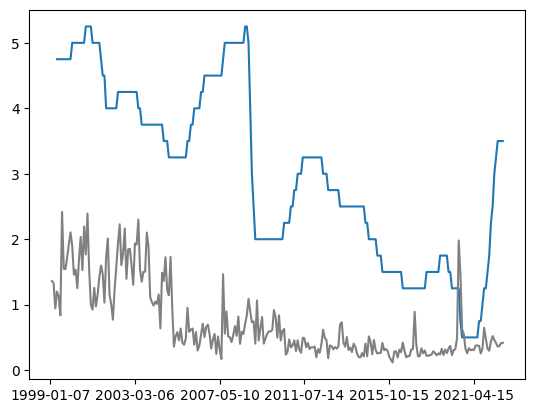

In [25]:
df["base_rate"].plot()
(df["dissimilarity"] * 5).plot(color="gray")

In [26]:
df

,cosine_similarity,dissimilarity,base_rate,base_rate_diff,FFR,ko-us_gap,governor,president,tr1,tr2
1999-01-07,NaN,NaN,NaN,NaN,4.750,NaN,전철환,김대중,NaN,NaN
1999-02-04,0.72794,0.27206,NaN,NaN,4.750,NaN,전철환,김대중,NaN,NaN
1999-03-04,0.733303,0.266697,NaN,NaN,4.750,NaN,전철환,김대중,NaN,NaN
1999-04-08,0.811213,0.188787,NaN,NaN,4.750,NaN,전철환,김대중,NaN,NaN
1999-05-06,0.759641,0.240359,4.75,NaN,4.750,0.000,전철환,김대중,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-11-24,0.917186,0.082814,3.25,1.0,3.875,-0.625,이창용,윤석열,7.225832,4.914102
2023-01-13,0.928007,0.071993,3.50,1.0,4.375,-0.875,이창용,윤석열,6.250150,1.879616
2023-02-23,0.926393,0.073607,3.50,0.0,4.625,-1.125,이창용,윤석열,6.250150,1.879616
2023-04-11,0.917157,0.082843,3.50,0.0,4.875,-1.375,이창용,윤석열,6.250150,1.879616


In [27]:
# 텍스트 데이터까지 포함하여 저장
rows = []
for date, v in tqdm(direction_statements.items()):
    row = {}
    raw = "\n".join(v["raw"])
    stem = v["stem"]
    row["date"] = date
    row["raw_statement"] = raw
    row["stem_statement"] = stem  # 어간
    rows.append(row)
    
df_text = pd.DataFrame(rows)
df_text.set_index("date", inplace=True, drop=True)

df_text_merged = pd.merge(df, df_text, left_index=True, right_index=True)  # 인덱스 기준으로 병합
df_text_merged.to_csv("./DATA/merged_data_with_text.csv")

100%|██████████| 268/268 [00:00<00:00, 475899.01it/s]
